In [1]:
%config Completer.use_jedi = False

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
CSV_FOLDER = "./grouped_data"
csv_files = [f for f in os.listdir(CSV_FOLDER) if ".csv" in f]
#csv_files

In [4]:
df = pd.DataFrame()
for csv in csv_files[:-3]:
    print(csv)
    temp = pd.read_csv(os.path.join(CSV_FOLDER, csv))
    df = df.append(temp)
    del temp

transactions_p1_2_2_1.csv
transactions_p2_1_1_1.csv
transactions_p2_2_2_2.csv
transactions_p2_2_2_1.csv
transactions_p1_1_1_2.csv
transactions_p2_1_2_2.csv
transactions_p1_2_1_1.csv
transactions_p2_2_1_1.csv
transactions_p1_2_1_2.csv
transactions_p1_1_1_1.csv
transactions_p2_1_1_2.csv
transactions_p1_1_2_2.csv
transactions_p1_2_2_2.csv


In [5]:
with open("user_return_ratio.txt") as f:
    user_return_ratio = eval(f.read())

In [6]:
type(user_return_ratio)

dict

In [7]:
df["user_return_ratio"] = df["user_id"].apply(lambda x: user_return_ratio[x])

In [8]:
df.is_returned.value_counts()

0.0    7380569
1.0    1108043
Name: is_returned, dtype: int64

In [9]:
df.is_returned.value_counts(normalize=True)

0.0    0.869467
1.0    0.130533
Name: is_returned, dtype: float64

In [10]:
#w0 = train.is_returned.sum()/train.shape[0]
#w1 = 1 - w0

In [11]:
#w0, w1

In [12]:
drop_cols = ['user_id', 'product_content_id', 'order_parent_id', 'is_returned']

In [13]:
group_cols = ["user_id", "product_content_id", "order_parent_id"]

In [14]:
sum(df[group_cols].duplicated())

0

In [15]:
df.columns

Index(['user_id', 'product_content_id', 'order_parent_id', 'is_returned',
       'is_elite_user', 'order_line_item_id', 'num_items_cart',
       'original_price_max', 'original_price_min', 'original_price_mean',
       'discounted_price_max', 'discounted_price_min', 'discounted_price_mean',
       'ship_cost_max', 'ship_cost_min', 'ship_cost_mean', 'has_coupon',
       'used_promo', 'is_wallet_trx', 'is_saved_card_trx', 'gender',
       'membership_year', 'brand_id', 'category_id', 'color_id',
       'attribute_value', 'original_discount_diff_max',
       'original_discount_diff_min', 'original_discount_diff_mean',
       'discount_div_original_max', 'discount_div_original_min',
       'discount_div_original_mean', 'returnRate_max', 'returnRate_min',
       'returnRate_mean', 'rate_min_max', 'rate_min_min', 'rate_min_mean',
       'rate_max_max', 'rate_max_min', 'rate_max_mean', 'rate_median_max',
       'rate_median_min', 'rate_median_mean', 'rate_mean_max', 'rate_mean_min',
       'r

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(drop_cols, axis=1),
                                                    df["is_returned"],
                                                   test_size=0.2,
                                                   stratify=df["is_returned"],
                                                   random_state=0)

In [17]:
del df

In [18]:
X_train.shape

(6790889, 47)

In [19]:
train = pd.concat([X_train, y_train], axis=1)

In [20]:
train_0 = train[train.is_returned == 0]
train_1 = train[train.is_returned == 1]

In [21]:
train_0.shape

(5904455, 48)

In [22]:
train_0.dropna(inplace=True)

In [23]:
train_0.shape

(5671538, 48)

In [24]:
zscore_cols = ["original_price_min", 
               "discounted_price_min", 
               "ship_cost_min", 
               "original_discount_diff_min",
               "rate_min_min",
               "discount_div_original_min"
              ]

In [25]:
from scipy.stats import zscore

zscore_abs = abs(zscore(train_0[zscore_cols]))

In [26]:
mask_zscore = (zscore_abs < 3).all(axis=1)

In [27]:
sum(mask_zscore)

5266665

In [28]:
train_0 = train_0[mask_zscore]

In [29]:
train = pd.concat([train_0, train_1])

In [30]:
del train_0, train_1

In [31]:
train.is_returned.value_counts()

0.0    5266665
1.0     886434
Name: is_returned, dtype: int64

In [32]:
X_train = train[X_test.columns]
y_train = train["is_returned"]

In [33]:
del train

In [ ]:
"""
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)
"""

In [34]:
#https://www.kaggle.com/code/mlisovyi/lighgbm-hyperoptimisation-with-f1-macro/notebook
from sklearn.metrics import f1_score

def lgb_f1_score(y_true, y_pred):
    y_true = y_true.astype(int)
    y_pred = np.where(y_pred >= 0.5, 1, 0).astype(int)
    return 'f1', f1_score(y_true, y_pred), True

In [35]:
import lightgbm as lgbm
import optuna

In [36]:
def objective(trial):
    
    
    params = {
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True, False]),
        "num_leaves": trial.suggest_int("num_leaves", 2, 128),
        "n_estimators": trial.suggest_categorical("n_estimators", range(100, 500, 100)),
        "learning_rate": trial.suggest_float("learning_rate",  0.01, 0.3),
        
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),

        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
     
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)}
   
    model = lgbm.LGBMClassifier(objective="binary", **params)
    model.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric = lgb_f1_score,
            early_stopping_rounds=200)
    preds = model.predict(X_test)
    
    score = f1_score(y_test,preds)
    return score

In [43]:
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2022-04-14 09:29:03,327] A new study created in memory with name: no-name-edc03ac6-0acf-4fd0-839e-eac3ecf7a6fd


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.636958258480544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.636958258480544
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[1]	valid_0's binary_logloss: 0.36417	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.347706	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.323785	valid_0's f1: 0
[4]	valid_0's binary_l

[I 2022-04-14 09:31:58,562] Trial 0 finished with value: 0.6221917261452286 and parameters: {'is_unbalance': False, 'num_leaves': 122, 'n_estimators': 200, 'learning_rate': 0.07669342044468137, 'min_data_in_leaf': 7900, 'lambda_l1': 5, 'lambda_l2': 15, 'min_gain_to_split': 10.636958258480544, 'bagging_fraction': 0.9, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.6221917261452286.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=6.150674395760585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.150674395760585
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[1]	valid_0's binary_logloss: 0.387748	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.388397	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.388061	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.374151	valid_0's f1: 0


[I 2022-04-14 09:34:59,383] Trial 1 finished with value: 0.15601731206397768 and parameters: {'is_unbalance': False, 'num_leaves': 74, 'n_estimators': 300, 'learning_rate': 0.05962231337572314, 'min_data_in_leaf': 4800, 'lambda_l1': 0, 'lambda_l2': 5, 'min_gain_to_split': 6.150674395760585, 'bagging_fraction': 0.9, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6221917261452286.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=3.1031318503274856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1031318503274856
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[1]	valid_0's binary_logloss: 0.360399	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.351651	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.333538	valid_0's f1: 0
[4]	valid_0's binar

[I 2022-04-14 09:37:42,563] Trial 2 finished with value: 0.49485091283352384 and parameters: {'is_unbalance': True, 'num_leaves': 23, 'n_estimators': 300, 'learning_rate': 0.09465361786253812, 'min_data_in_leaf': 3300, 'lambda_l1': 55, 'lambda_l2': 65, 'min_gain_to_split': 3.1031318503274856, 'bagging_fraction': 0.7, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.6221917261452286.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=5.704634900476644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.704634900476644
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[1]	valid_0's binary_logloss: 0.388238	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.391705	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.396324	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.388615	valid_0's f1

[I 2022-04-14 09:40:31,841] Trial 3 finished with value: 0.1067613140579676 and parameters: {'is_unbalance': True, 'num_leaves': 30, 'n_estimators': 300, 'learning_rate': 0.05158077885802874, 'min_data_in_leaf': 9300, 'lambda_l1': 60, 'lambda_l2': 30, 'min_gain_to_split': 5.704634900476644, 'bagging_fraction': 0.8, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6221917261452286.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=12.76782974295067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.76782974295067
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[1]	valid_0's binary_logloss: 0.38864	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.389262	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.389534	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.387118	valid_0's f1: 0

[I 2022-04-14 09:43:41,794] Trial 4 finished with value: 0.4065749988802795 and parameters: {'is_unbalance': False, 'num_leaves': 2, 'n_estimators': 300, 'learning_rate': 0.020669719987412127, 'min_data_in_leaf': 7600, 'lambda_l1': 50, 'lambda_l2': 0, 'min_gain_to_split': 12.76782974295067, 'bagging_fraction': 0.2, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6221917261452286.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=2.5570099058236195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5570099058236195
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[1]	valid_0's binary_logloss: 0.394624	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.411624	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.429784	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.420959	valid_0's 

[I 2022-04-14 09:46:42,088] Trial 5 finished with value: 0.0 and parameters: {'is_unbalance': True, 'num_leaves': 58, 'n_estimators': 400, 'learning_rate': 0.12056101582510526, 'min_data_in_leaf': 4700, 'lambda_l1': 95, 'lambda_l2': 60, 'min_gain_to_split': 2.5570099058236195, 'bagging_fraction': 0.4, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6221917261452286.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=13.163097211658933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.163097211658933
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[1]	valid_0's binary_logloss: 0.362762	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.351974	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.340179	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.333521	valid_0's 

[I 2022-04-14 09:48:25,342] Trial 6 finished with value: 0.0 and parameters: {'is_unbalance': True, 'num_leaves': 91, 'n_estimators': 100, 'learning_rate': 0.07785130597242625, 'min_data_in_leaf': 2400, 'lambda_l1': 10, 'lambda_l2': 30, 'min_gain_to_split': 13.163097211658933, 'bagging_fraction': 0.7, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.6221917261452286.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.703200989726643, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.703200989726643
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[1]	valid_0's binary_logloss: 0.36103	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.337201	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.322307	valid_0's f1: 0
[4]	valid_0's binary

[I 2022-04-14 09:50:12,697] Trial 7 finished with value: 0.5972446599245156 and parameters: {'is_unbalance': True, 'num_leaves': 78, 'n_estimators': 100, 'learning_rate': 0.08359834815838899, 'min_data_in_leaf': 300, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 12.703200989726643, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.6221917261452286.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=4.215588001290615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.215588001290615
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[1]	valid_0's binary_logloss: 0.399299	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.422527	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.445725	valid_0's f1: 0.0438953
[4]	valid_0

[I 2022-04-14 09:51:44,273] Trial 8 finished with value: 0.0 and parameters: {'is_unbalance': True, 'num_leaves': 35, 'n_estimators': 100, 'learning_rate': 0.1430832159350956, 'min_data_in_leaf': 4100, 'lambda_l1': 100, 'lambda_l2': 0, 'min_gain_to_split': 4.215588001290615, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6221917261452286.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=2.4030051675102717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4030051675102717
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[1]	valid_0's binary_logloss: 0.389379	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.392552	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.393466	valid_0's f1: 0
[4]	valid_0's binar

[I 2022-04-14 09:53:06,258] Trial 9 finished with value: 0.2818438669002515 and parameters: {'is_unbalance': False, 'num_leaves': 14, 'n_estimators': 100, 'learning_rate': 0.09541465972476317, 'min_data_in_leaf': 2300, 'lambda_l1': 25, 'lambda_l2': 75, 'min_gain_to_split': 2.4030051675102717, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6221917261452286.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=9.486041881612687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.486041881612687
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[1]	valid_0's binary_logloss: 0.330108	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.280305	valid_0's f1: 0.469829
[3]	valid_0's binary_logloss: 0.251947	valid_0's f1: 0.553439
[4]	valid_0's binary_logloss: 0.23414

[I 2022-04-14 09:55:28,301] Trial 10 finished with value: 0.6623886032759143 and parameters: {'is_unbalance': False, 'num_leaves': 126, 'n_estimators': 200, 'learning_rate': 0.23191668302470808, 'min_data_in_leaf': 6900, 'lambda_l1': 35, 'lambda_l2': 95, 'min_gain_to_split': 9.486041881612687, 'bagging_fraction': 0.9, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.6623886032759143.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=9.64582498715116, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.64582498715116
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[1]	valid_0's binary_logloss: 0.330014	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.280243	valid_0's f1: 0.482198
[3]	valid_0's binary_logloss: 0.251796	valid_0's f1: 0.552856
[4]	valid_0's binary_logloss: 0.23392

[I 2022-04-14 09:57:49,611] Trial 11 finished with value: 0.6617131461288558 and parameters: {'is_unbalance': False, 'num_leaves': 126, 'n_estimators': 200, 'learning_rate': 0.23249336212116567, 'min_data_in_leaf': 7100, 'lambda_l1': 30, 'lambda_l2': 100, 'min_gain_to_split': 9.64582498715116, 'bagging_fraction': 0.9, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.6623886032759143.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=9.154161667673893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.154161667673893
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[1]	valid_0's binary_logloss: 0.329563	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.279676	valid_0's f1: 0.488587
[3]	valid_0's binary_logloss: 0.251408	valid_0's f1: 0.561123
[4]	valid_0's binary_logloss: 0.23398

[I 2022-04-14 10:00:12,135] Trial 12 finished with value: 0.647708602244025 and parameters: {'is_unbalance': False, 'num_leaves': 127, 'n_estimators': 200, 'learning_rate': 0.23688956113701265, 'min_data_in_leaf': 6700, 'lambda_l1': 35, 'lambda_l2': 95, 'min_gain_to_split': 9.154161667673893, 'bagging_fraction': 0.9, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.6623886032759143.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.940230122222639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.940230122222639
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[1]	valid_0's binary_logloss: 0.331197	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.283122	valid_0's f1: 0.450547
[3]	valid_0's binary_logloss: 0.255046	valid_0's f1: 0.540248
[4]	valid_0's binary_logloss: 0.237

[I 2022-04-14 10:02:35,295] Trial 13 finished with value: 0.645720412983088 and parameters: {'is_unbalance': False, 'num_leaves': 109, 'n_estimators': 200, 'learning_rate': 0.22487861287423477, 'min_data_in_leaf': 6300, 'lambda_l1': 40, 'lambda_l2': 100, 'min_gain_to_split': 8.940230122222639, 'bagging_fraction': 0.5, 'feature_fraction': 0.9}. Best is trial 10 with value: 0.6623886032759143.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.67935839747179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.67935839747179
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[1]	valid_0's binary_logloss: 0.324618	valid_0's f1: 0.342442
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.269784	valid_0's f1: 0.532408
[3]	valid_0's binary_logloss: 0.242144	valid_0's f1: 0.585442
[4]	valid_0's binary_logloss: 

[I 2022-04-14 10:04:54,853] Trial 14 finished with value: 0.6626350269593863 and parameters: {'is_unbalance': False, 'num_leaves': 101, 'n_estimators': 200, 'learning_rate': 0.2899210888768983, 'min_data_in_leaf': 9000, 'lambda_l1': 75, 'lambda_l2': 85, 'min_gain_to_split': 10.67935839747179, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}. Best is trial 14 with value: 0.6626350269593863.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=14.853494088798215, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.853494088798215
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[1]	valid_0's binary_logloss: 0.325102	valid_0's f1: 0.342442
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.313783	valid_0's f1: 0.444161
[3]	valid_0's binary_logloss: 0.270501	valid_0's f1: 0.494237
[4]	valid_0's binary_logloss

[I 2022-04-14 10:07:14,313] Trial 15 finished with value: 0.6477647184851739 and parameters: {'is_unbalance': False, 'num_leaves': 101, 'n_estimators': 200, 'learning_rate': 0.28323353745162383, 'min_data_in_leaf': 9700, 'lambda_l1': 70, 'lambda_l2': 80, 'min_gain_to_split': 14.853494088798215, 'bagging_fraction': 0.7, 'feature_fraction': 0.7}. Best is trial 14 with value: 0.6626350269593863.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.2937278160193122, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2937278160193122
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[1]	valid_0's binary_logloss: 0.324312	valid_0's f1: 0.348539
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.269276	valid_0's f1: 0.533473
[3]	valid_0's binary_logloss: 0.241678	valid_0's f1: 0.589779
[4]	valid_0's binary_logloss

[I 2022-04-14 10:10:09,126] Trial 16 finished with value: 0.662716497455532 and parameters: {'is_unbalance': False, 'num_leaves': 107, 'n_estimators': 400, 'learning_rate': 0.29421655771573885, 'min_data_in_leaf': 8500, 'lambda_l1': 80, 'lambda_l2': 85, 'min_gain_to_split': 0.2937278160193122, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.9127427168258748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9127427168258748
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[1]	valid_0's binary_logloss: 0.331	valid_0's f1: 0.326858
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.320422	valid_0's f1: 0.405205
[3]	valid_0's binary_logloss: 0.2847	valid_0's f1: 0.460735
[4]

[I 2022-04-14 10:12:55,624] Trial 17 finished with value: 0.5434953908975225 and parameters: {'is_unbalance': False, 'num_leaves': 54, 'n_estimators': 400, 'learning_rate': 0.2941920953854536, 'min_data_in_leaf': 8800, 'lambda_l1': 85, 'lambda_l2': 80, 'min_gain_to_split': 0.9127427168258748, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.4}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.76672528011404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.76672528011404
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[1]	valid_0's binary_logloss: 0.335457	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.318762	valid_0's f1: 0.0937231
[3]	valid_0's binary_logloss: 0.282528	valid_0's f1: 0.498718
[4]	valid_0's binary_logloss: 0.258861

[I 2022-04-14 10:15:30,856] Trial 18 finished with value: 0.6498681911498765 and parameters: {'is_unbalance': False, 'num_leaves': 94, 'n_estimators': 400, 'learning_rate': 0.192989572481856, 'min_data_in_leaf': 8500, 'lambda_l1': 80, 'lambda_l2': 50, 'min_gain_to_split': 6.76672528011404, 'bagging_fraction': 0.8, 'feature_fraction': 0.7}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.986320171989587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.986320171989587
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[1]	valid_0's binary_logloss: 0.326499	valid_0's f1: 0.0933346
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.287933	valid_0's f1: 0.469965
[3]	valid_0's binary_logloss: 0.259415	valid_0's f1: 0.521468
[4]	valid_0's binary_logloss:

[I 2022-04-14 10:18:16,355] Trial 19 finished with value: 0.6460567492896518 and parameters: {'is_unbalance': False, 'num_leaves': 111, 'n_estimators': 400, 'learning_rate': 0.2731366188621658, 'min_data_in_leaf': 5800, 'lambda_l1': 70, 'lambda_l2': 85, 'min_gain_to_split': 0.986320171989587, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=11.273972400001188, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.273972400001188
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[1]	valid_0's binary_logloss: 0.337123	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.319312	valid_0's f1: 0.00852345
[3]	valid_0's binary_logloss: 0.28213	valid_0's f1: 0.490028
[4]	valid_0's binary_logloss: 0.

[I 2022-04-14 10:20:48,401] Trial 20 finished with value: 0.6468498252013984 and parameters: {'is_unbalance': False, 'num_leaves': 81, 'n_estimators': 400, 'learning_rate': 0.18583821403717715, 'min_data_in_leaf': 10000, 'lambda_l1': 85, 'lambda_l2': 65, 'min_gain_to_split': 11.273972400001188, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.543471737529162, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.543471737529162
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[1]	valid_0's binary_logloss: 0.326531	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.275956	valid_0's f1: 0.50814
[3]	valid_0's binary_logloss: 0.247842	valid_0's f1: 0.56623
[4]	valid_0's binary_logloss: 0.23015	v

[I 2022-04-14 10:23:12,797] Trial 21 finished with value: 0.6590519728876467 and parameters: {'is_unbalance': False, 'num_leaves': 113, 'n_estimators': 200, 'learning_rate': 0.26003013129719266, 'min_data_in_leaf': 8200, 'lambda_l1': 70, 'lambda_l2': 90, 'min_gain_to_split': 7.543471737529162, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.729554393642745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.729554393642745
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[1]	valid_0's binary_logloss: 0.328268	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.289732	valid_0's f1: 0.460433
[3]	valid_0's binary_logloss: 0.2606	valid_0's f1: 0.51096
[4]	valid_0's binary_logloss: 0.242582

[I 2022-04-14 10:25:21,293] Trial 22 finished with value: 0.6419085984776697 and parameters: {'is_unbalance': False, 'num_leaves': 100, 'n_estimators': 200, 'learning_rate': 0.25332960977706515, 'min_data_in_leaf': 5800, 'lambda_l1': 45, 'lambda_l2': 75, 'min_gain_to_split': 11.729554393642745, 'bagging_fraction': 0.7, 'feature_fraction': 0.8}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.135386083069275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.135386083069275
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[1]	valid_0's binary_logloss: 0.33611	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.289424	valid_0's f1: 0.132857
[3]	valid_0's binary_logloss: 0.26157	valid_0's f1: 0.513614
[4]	valid_0's binary_logloss: 0.242991	

[I 2022-04-14 10:27:32,356] Trial 23 finished with value: 0.6614245046391959 and parameters: {'is_unbalance': False, 'num_leaves': 114, 'n_estimators': 200, 'learning_rate': 0.19185794091813468, 'min_data_in_leaf': 7500, 'lambda_l1': 60, 'lambda_l2': 90, 'min_gain_to_split': 8.135386083069275, 'bagging_fraction': 0.8, 'feature_fraction': 0.9}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=5.028388953106055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.028388953106055
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[1]	valid_0's binary_logloss: 0.324491	valid_0's f1: 0.348539
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.313524	valid_0's f1: 0.456098
[3]	valid_0's binary_logloss: 0.268972	valid_0's f1: 0.502879
[4]	valid_0's binary_logloss: 

[I 2022-04-14 10:29:44,538] Trial 24 finished with value: 0.6500299424042247 and parameters: {'is_unbalance': False, 'num_leaves': 89, 'n_estimators': 400, 'learning_rate': 0.2980345603845177, 'min_data_in_leaf': 9000, 'lambda_l1': 80, 'lambda_l2': 55, 'min_gain_to_split': 5.028388953106055, 'bagging_fraction': 0.9, 'feature_fraction': 0.7}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.126195300461635, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.126195300461635
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[1]	valid_0's binary_logloss: 0.327834	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.27856	valid_0's f1: 0.508339
[3]	valid_0's binary_logloss: 0.250822	valid_0's f1: 0.563196
[4]	va

[I 2022-04-14 10:31:48,573] Trial 25 finished with value: 0.6505462685569823 and parameters: {'is_unbalance': False, 'num_leaves': 103, 'n_estimators': 200, 'learning_rate': 0.2572806410009761, 'min_data_in_leaf': 6800, 'lambda_l1': 90, 'lambda_l2': 70, 'min_gain_to_split': 10.126195300461635, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.8}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=8.03777514789138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.03777514789138
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[1]	valid_0's binary_logloss: 0.337167	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.320438	valid_0's f1: 0.257579
[3]	valid_0's binary_logloss: 0.290972	valid_0's f1: 0.412215
[4]	valid_0's binary_logloss: 0.275183	

[I 2022-04-14 10:34:09,438] Trial 26 finished with value: 0.5120217362010598 and parameters: {'is_unbalance': False, 'num_leaves': 118, 'n_estimators': 200, 'learning_rate': 0.21002626145452974, 'min_data_in_leaf': 8300, 'lambda_l1': 65, 'lambda_l2': 45, 'min_gain_to_split': 8.03777514789138, 'bagging_fraction': 0.8, 'feature_fraction': 0.4}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=14.450294724696832, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.450294724696832
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[1]	valid_0's binary_logloss: 0.342631	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.306204	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.277961	valid_0's f1: 0.405387
[4]	valid_0's binary_logloss: 0.257935	val

[I 2022-04-14 10:36:23,599] Trial 27 finished with value: 0.6564496005660975 and parameters: {'is_unbalance': False, 'num_leaves': 62, 'n_estimators': 400, 'learning_rate': 0.16282460825466755, 'min_data_in_leaf': 5800, 'lambda_l1': 75, 'lambda_l2': 90, 'min_gain_to_split': 14.450294724696832, 'bagging_fraction': 0.7, 'feature_fraction': 0.9}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=11.69622647580953, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.69622647580953
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[1]	valid_0's binary_logloss: 0.330185	valid_0's f1: 0.0746386
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.316165	valid_0's f1: 0.400309
[3]	valid_0's binary_logloss: 0.272334	valid_0's f1: 0.4770

[I 2022-04-14 10:38:31,168] Trial 28 finished with value: 0.6324157682902461 and parameters: {'is_unbalance': False, 'num_leaves': 72, 'n_estimators': 200, 'learning_rate': 0.27529358030625833, 'min_data_in_leaf': 9600, 'lambda_l1': 50, 'lambda_l2': 100, 'min_gain_to_split': 11.69622647580953, 'bagging_fraction': 0.9, 'feature_fraction': 0.6000000000000001}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.10315462267664824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10315462267664824
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[1]	valid_0's binary_logloss: 0.332326	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.316483	valid_0's f1: 0.383849
[3]	valid_0's binary_logloss: 0.275479	valid_0's f1: 0.469216
[4]

[I 2022-04-14 10:41:34,387] Trial 29 finished with value: 0.6234819181460398 and parameters: {'is_unbalance': False, 'num_leaves': 120, 'n_estimators': 200, 'learning_rate': 0.2412960487352557, 'min_data_in_leaf': 7800, 'lambda_l1': 10, 'lambda_l2': 85, 'min_gain_to_split': 0.10315462267664824, 'bagging_fraction': 0.9, 'feature_fraction': 0.6000000000000001}. Best is trial 16 with value: 0.662716497455532.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.662135031578302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.662135031578302
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[1]	valid_0's binary_logloss: 0.334344	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.284807	valid_0's f1: 0.409303
[3]	valid_0's binary_logloss: 0.256535	valid_0's f1: 0.523277
[4]	valid_0's binary_logloss: 0.240

[I 2022-04-14 10:43:45,399] Trial 30 finished with value: 0.6668901958712931 and parameters: {'is_unbalance': False, 'num_leaves': 46, 'n_estimators': 400, 'learning_rate': 0.21192391689302947, 'min_data_in_leaf': 8900, 'lambda_l1': 20, 'lambda_l2': 75, 'min_gain_to_split': 10.662135031578302, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}. Best is trial 30 with value: 0.6668901958712931.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.42866037779076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.42866037779076
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[1]	valid_0's binary_logloss: 0.333984	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.28415	valid_0's f1: 0.428031
[3]	valid_0's binary_logloss: 0.255826	valid_0's f1: 0.522561
[4]	valid_0's binary_logloss: 0.239541

[I 2022-04-14 10:45:57,566] Trial 31 finished with value: 0.6691642348839703 and parameters: {'is_unbalance': False, 'num_leaves': 45, 'n_estimators': 400, 'learning_rate': 0.21510879711707329, 'min_data_in_leaf': 8900, 'lambda_l1': 20, 'lambda_l2': 80, 'min_gain_to_split': 10.42866037779076, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.597122499478148, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.597122499478148
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[1]	valid_0's binary_logloss: 0.33423	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.284672	valid_0's f1: 0.409303
[3]	valid_0's binary_logloss: 0.256448	valid_0's f1: 0.521346
[4]	valid_0's binary_logloss: 0.2396

[I 2022-04-14 10:48:09,677] Trial 32 finished with value: 0.6679477395805559 and parameters: {'is_unbalance': False, 'num_leaves': 47, 'n_estimators': 400, 'learning_rate': 0.21169737054964377, 'min_data_in_leaf': 9000, 'lambda_l1': 15, 'lambda_l2': 75, 'min_gain_to_split': 10.597122499478148, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=10.739326781029758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.739326781029758
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[1]	valid_0's binary_logloss: 0.343161	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.325889	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.290073	valid_0's f1: 0.369805
[4]	valid_0's binary_logloss: 0.266921	valid

[I 2022-04-14 10:50:29,498] Trial 33 finished with value: 0.6389995687025546 and parameters: {'is_unbalance': False, 'num_leaves': 47, 'n_estimators': 400, 'learning_rate': 0.15983270732114105, 'min_data_in_leaf': 8200, 'lambda_l1': 0, 'lambda_l2': 70, 'min_gain_to_split': 10.739326781029758, 'bagging_fraction': 0.7, 'feature_fraction': 0.7}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.038408617061557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.038408617061557
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[1]	valid_0's binary_logloss: 0.335642	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.286719	valid_0's f1: 0.349898
[3]	valid_0's binary_logloss: 0.258426	valid_0's f1: 0.521949
[4]	valid_0's binary_logloss: 0.242

[I 2022-04-14 10:52:47,158] Trial 34 finished with value: 0.6670180591167928 and parameters: {'is_unbalance': False, 'num_leaves': 44, 'n_estimators': 400, 'learning_rate': 0.20448792136604538, 'min_data_in_leaf': 10000, 'lambda_l1': 15, 'lambda_l2': 65, 'min_gain_to_split': 7.038408617061557, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.763253581336593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.763253581336593
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[1]	valid_0's binary_logloss: 0.347692	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.355763	valid_0's f1: 0.414453
[3]	valid_0's binary_logloss: 0.327312	valid_0's f1: 0.598806
[4]	valid_0's binary_logloss: 0.31233

[I 2022-04-14 10:55:12,201] Trial 35 finished with value: 0.6475924609555621 and parameters: {'is_unbalance': True, 'num_leaves': 44, 'n_estimators': 400, 'learning_rate': 0.20988825440396197, 'min_data_in_leaf': 9300, 'lambda_l1': 15, 'lambda_l2': 60, 'min_gain_to_split': 6.763253581336593, 'bagging_fraction': 0.7, 'feature_fraction': 0.7}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=13.576550395730825, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.576550395730825
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[1]	valid_0's binary_logloss: 0.343231	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.325941	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.29697	valid_0's f1: 0.266607
[4]	valid_0

[I 2022-04-14 10:57:43,596] Trial 36 finished with value: 0.6147683274760776 and parameters: {'is_unbalance': False, 'num_leaves': 38, 'n_estimators': 400, 'learning_rate': 0.17650785015482623, 'min_data_in_leaf': 10000, 'lambda_l1': 20, 'lambda_l2': 65, 'min_gain_to_split': 13.576550395730825, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.5}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=8.278121264241587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.278121264241587
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[1]	valid_0's binary_logloss: 0.351156	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.31544	valid_0's f1: 0.460432
[3]	valid_0's binary_logloss: 0.299509	valid_0's f1: 0.639076
[4]	valid_0's binary_logloss: 0.293863	v

[I 2022-04-14 11:00:13,524] Trial 37 finished with value: 0.6574273120100753 and parameters: {'is_unbalance': True, 'num_leaves': 23, 'n_estimators': 300, 'learning_rate': 0.2069547482699023, 'min_data_in_leaf': 9300, 'lambda_l1': 5, 'lambda_l2': 45, 'min_gain_to_split': 8.278121264241587, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.3040488136104385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.3040488136104385
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7600
[1]	valid_0's binary_logloss: 0.35162	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.333049	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.300029	valid_0's f1: 0.00775002
[4]	valid_0

[I 2022-04-14 11:02:50,249] Trial 38 finished with value: 0.618907506960103 and parameters: {'is_unbalance': False, 'num_leaves': 49, 'n_estimators': 400, 'learning_rate': 0.13374710509023185, 'min_data_in_leaf': 7600, 'lambda_l1': 25, 'lambda_l2': 75, 'min_gain_to_split': 6.3040488136104385, 'bagging_fraction': 0.7, 'feature_fraction': 0.6000000000000001}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=12.29334607125518, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.29334607125518
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[1]	valid_0's binary_logloss: 0.350829	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.360373	valid_0's f1: 0.404422
[3]	valid_0's binary_logloss: 0.331571	valid_0's f1: 0.612487
[4]	valid_0's binary_logloss: 0.31695

[I 2022-04-14 11:05:08,735] Trial 39 finished with value: 0.6400790046226468 and parameters: {'is_unbalance': True, 'num_leaves': 26, 'n_estimators': 400, 'learning_rate': 0.21524102951226032, 'min_data_in_leaf': 8900, 'lambda_l1': 15, 'lambda_l2': 15, 'min_gain_to_split': 12.29334607125518, 'bagging_fraction': 0.8, 'feature_fraction': 0.7}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=4.957375064069163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.957375064069163
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[1]	valid_0's binary_logloss: 0.346451	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.310327	valid_0's f1: 0.0366292
[3]	valid_0's binary_logloss: 0.281231	valid_0's f1: 0.437823
[4]	valid_0's binary_logloss: 0.261596

[I 2022-04-14 11:07:28,050] Trial 40 finished with value: 0.625 and parameters: {'is_unbalance': False, 'num_leaves': 16, 'n_estimators': 300, 'learning_rate': 0.1724390206726418, 'min_data_in_leaf': 1200, 'lambda_l1': 5, 'lambda_l2': 60, 'min_gain_to_split': 4.957375064069163, 'bagging_fraction': 0.9, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=3.8584060645009757, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8584060645009757
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[1]	valid_0's binary_logloss: 0.335203	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.287074	valid_0's f1: 0.247615
[3]	valid_0's binary_logloss: 0.258962	valid_0's f1: 0.522217
[4]	valid_0's binary_logloss: 0.242

[I 2022-04-14 11:09:50,003] Trial 41 finished with value: 0.6657098109099928 and parameters: {'is_unbalance': False, 'num_leaves': 68, 'n_estimators': 400, 'learning_rate': 0.1978326110994133, 'min_data_in_leaf': 8600, 'lambda_l1': 15, 'lambda_l2': 70, 'min_gain_to_split': 3.8584060645009757, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=10.317648245036715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.317648245036715
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[1]	valid_0's binary_logloss: 0.336501	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.288378	valid_0's f1: 0.147786
[3]	valid_0's binary_logloss: 0.260417	valid_0's f1: 0.506692
[4]	valid_0's binary_logloss: 0.242

[I 2022-04-14 11:12:03,640] Trial 42 finished with value: 0.6684166224153564 and parameters: {'is_unbalance': False, 'num_leaves': 65, 'n_estimators': 400, 'learning_rate': 0.19122975910605083, 'min_data_in_leaf': 9600, 'lambda_l1': 15, 'lambda_l2': 70, 'min_gain_to_split': 10.317648245036715, 'bagging_fraction': 0.7, 'feature_fraction': 0.9}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=10.439079504333252, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.439079504333252
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[1]	valid_0's binary_logloss: 0.33392	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.282761	valid_0's f1: 0.435227
[3]	valid_0's binary_logloss: 0.254481	valid_0's f1: 0.527809
[4]	valid_0's binary_logloss: 0.2372

[I 2022-04-14 11:14:16,170] Trial 43 finished with value: 0.6617827067323178 and parameters: {'is_unbalance': False, 'num_leaves': 39, 'n_estimators': 400, 'learning_rate': 0.2211163260516117, 'min_data_in_leaf': 9600, 'lambda_l1': 25, 'lambda_l2': 80, 'min_gain_to_split': 10.439079504333252, 'bagging_fraction': 0.7, 'feature_fraction': 0.9}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.78120028441973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.78120028441973
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[1]	valid_0's binary_logloss: 0.3388	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.291993	valid_0's f1: 0.00859302
[3]	valid_0's binary_logloss: 0.264095	valid_0's f1: 0.487491
[4]	valid_0's binary_logloss: 0.246754	

[I 2022-04-14 11:16:31,337] Trial 44 finished with value: 0.6613132454959498 and parameters: {'is_unbalance': False, 'num_leaves': 54, 'n_estimators': 400, 'learning_rate': 0.1787946875268835, 'min_data_in_leaf': 9300, 'lambda_l1': 10, 'lambda_l2': 65, 'min_gain_to_split': 8.78120028441973, 'bagging_fraction': 0.7, 'feature_fraction': 0.9}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=9.832782512693134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.832782512693134
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[1]	valid_0's binary_logloss: 0.381395	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.371998	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.36345	valid_0's f1: 0
[4]	valid_0's binary_logloss: 0.355549	valid_0's f

[I 2022-04-14 11:17:42,895] Trial 45 finished with value: 0.6615261898431269 and parameters: {'is_unbalance': False, 'num_leaves': 32, 'n_estimators': 100, 'learning_rate': 0.020426310332595926, 'min_data_in_leaf': 10000, 'lambda_l1': 30, 'lambda_l2': 55, 'min_gain_to_split': 9.832782512693134, 'bagging_fraction': 0.9, 'feature_fraction': 0.9}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=12.501403677687744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.501403677687744
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[1]	valid_0's binary_logloss: 0.352023	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.367048	valid_0's f1: 0
[3]	valid_0's binary_logloss: 0.348566	valid

[I 2022-04-14 11:20:16,888] Trial 46 finished with value: 0.11772878582712706 and parameters: {'is_unbalance': True, 'num_leaves': 60, 'n_estimators': 400, 'learning_rate': 0.14763033957691382, 'min_data_in_leaf': 8000, 'lambda_l1': 0, 'lambda_l2': 75, 'min_gain_to_split': 12.501403677687744, 'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.30000000000000004}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.148754540753263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.148754540753263
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[1]	valid_0's binary_logloss: 0.33291	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.294675	valid_0's f1: 0.441972
[3]	valid_0's binary_logloss: 0.276227	valid_0's f1: 0.491155
[4]	valid_0's binary_logloss: 0.2573

[I 2022-04-14 11:22:26,422] Trial 47 finished with value: 0.6360972059463804 and parameters: {'is_unbalance': False, 'num_leaves': 43, 'n_estimators': 400, 'learning_rate': 0.24619022046901112, 'min_data_in_leaf': 4200, 'lambda_l1': 20, 'lambda_l2': 70, 'min_gain_to_split': 11.148754540753263, 'bagging_fraction': 0.5, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=9.382198200860682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.382198200860682
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[1]	valid_0's binary_logloss: 0.336799	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.287663	valid_0's f1: 0.334805
[3]	valid_0's binary_logloss: 0.259724	valid_0's f1: 0.515014
[4]	valid_0's binary_logloss: 0.24067

[I 2022-04-14 11:24:39,752] Trial 48 finished with value: 0.659158946441884 and parameters: {'is_unbalance': False, 'num_leaves': 53, 'n_estimators': 400, 'learning_rate': 0.20075553483705613, 'min_data_in_leaf': 7400, 'lambda_l1': 30, 'lambda_l2': 55, 'min_gain_to_split': 9.382198200860682, 'bagging_fraction': 0.8, 'feature_fraction': 0.9}. Best is trial 31 with value: 0.6691642348839703.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.340597344546075, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.340597344546075
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[1]	valid_0's binary_logloss: 0.331895	valid_0's f1: 0
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.294004	valid_0's f1: 0.398868
[3]	valid_0's binary_logloss: 0.275339	valid_0's f1: 0.494444
[4]	valid_0's binary_logloss: 0.26658

[I 2022-04-14 11:26:52,460] Trial 49 finished with value: 0.6353420436444035 and parameters: {'is_unbalance': False, 'num_leaves': 68, 'n_estimators': 300, 'learning_rate': 0.2261151425397615, 'min_data_in_leaf': 3000, 'lambda_l1': 40, 'lambda_l2': 80, 'min_gain_to_split': 7.340597344546075, 'bagging_fraction': 0.4, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.6691642348839703.


In [48]:
best_params = study.best_params
best_params

{'is_unbalance': False,
 'num_leaves': 45,
 'n_estimators': 400,
 'learning_rate': 0.21510879711707329,
 'min_data_in_leaf': 8900,
 'lambda_l1': 20,
 'lambda_l2': 80,
 'min_gain_to_split': 10.42866037779076,
 'bagging_fraction': 0.8,
 'feature_fraction': 0.8}

In [45]:
study.best_trial

FrozenTrial(number=31, values=[0.6691642348839703], datetime_start=datetime.datetime(2022, 4, 14, 10, 43, 45, 399743), datetime_complete=datetime.datetime(2022, 4, 14, 10, 45, 57, 566382), params={'is_unbalance': False, 'num_leaves': 45, 'n_estimators': 400, 'learning_rate': 0.21510879711707329, 'min_data_in_leaf': 8900, 'lambda_l1': 20, 'lambda_l2': 80, 'min_gain_to_split': 10.42866037779076, 'bagging_fraction': 0.8, 'feature_fraction': 0.8}, distributions={'is_unbalance': CategoricalDistribution(choices=(True, False)), 'num_leaves': IntUniformDistribution(high=128, low=2, step=1), 'n_estimators': CategoricalDistribution(choices=(100, 200, 300, 400)), 'learning_rate': UniformDistribution(high=0.3, low=0.01), 'min_data_in_leaf': IntUniformDistribution(high=10000, low=200, step=100), 'lambda_l1': IntUniformDistribution(high=100, low=0, step=5), 'lambda_l2': IntUniformDistribution(high=100, low=0, step=5), 'min_gain_to_split': UniformDistribution(high=15.0, low=0.0), 'bagging_fraction': 

In [50]:
best_model = lgbm.LGBMClassifier(random_state=0, **best_params)

In [51]:
best_model.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=10.42866037779076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.42866037779076
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.8, is_unbalance=False,
               lambda_l1=20, lambda_l2=80, learning_rate=0.21510879711707329,
               min_data_in_leaf=8900, min_gain_to_split=10.42866037779076,
               n_estimators=400, num_leaves=45, random_state=0)

In [52]:
best_model_pred = best_model.predict(X_test)

print("f1 binary:", f1_score(y_test, best_model_pred))
print(confusion_matrix(y_test, best_model_pred))
print(classification_report(y_test, best_model_pred))

f1 binary: 0.6457776502824132
[[1355467  120647]
 [  58400  163209]]
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94   1476114
         1.0       0.57      0.74      0.65    221609

    accuracy                           0.89   1697723
   macro avg       0.77      0.83      0.79   1697723
weighted avg       0.91      0.89      0.90   1697723



In [37]:
model = lgbm.LGBMClassifier(random_state=0)

In [38]:
%%time
model.fit(X_train, y_train)

CPU times: user 4min 59s, sys: 1.96 s, total: 5min 1s
Wall time: 28.1 s


LGBMClassifier(random_state=0)

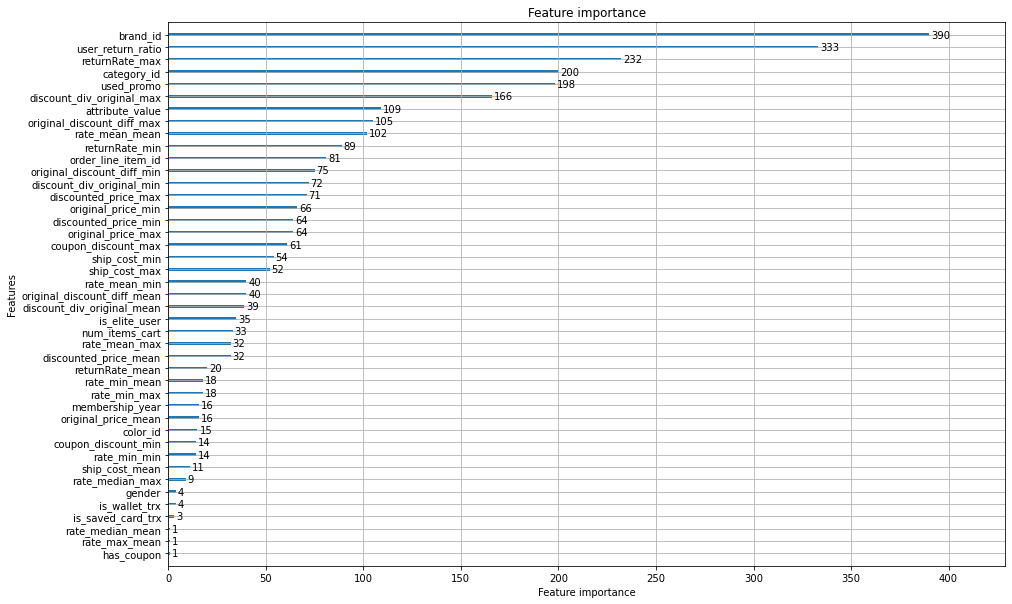

In [41]:
lgbm.plot_importance(model, figsize=(15, 10));

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

preds = model.predict(X_test)
print("f1 binary:", f1_score(y_test, preds))
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

f1 binary: 0.6354256788030647
[[1348364  127750]
 [  58927  162682]]
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94   1476114
         1.0       0.56      0.73      0.64    221609

    accuracy                           0.89   1697723
   macro avg       0.76      0.82      0.79   1697723
weighted avg       0.91      0.89      0.90   1697723



In [53]:
test_data = pd.read_csv("test_data.csv")
test_data

,id,expected
0,18115|87073974|726348863,NaN
1,27588|118753298|723169934,NaN
2,29165|35699988|724122443,NaN
3,29969|5893187|722342150,NaN
4,35107|93897418|723421057,NaN
...,...,...
7466,71083899|100019570|728638514,NaN
7467,71106534|35624085|725372928,NaN
7468,71115350|94438742|725291348,NaN
7469,71115350|100017676|725291348,NaN


In [54]:
test_feats = pd.read_csv("test_feats.csv")
test_feats

,user_id,product_content_id,order_parent_id,is_returned,is_elite_user,order_line_item_id,num_items_cart,original_price_max,original_price_min,original_price_mean,...,rate_max_mean,rate_median_max,rate_median_min,rate_median_mean,rate_mean_max,rate_mean_min,rate_mean_mean,coupon_discount_max,coupon_discount_min,coupon_discount_mean
0,2141,80306720,726403811,NaN,0,1,1,229.990000,229.990000,229.990000,...,4.0,4.0,4.0,4.0,4.000000,4.000000,4.000000,0.0,0.0,0.0
1,2472,74477923,728406577,NaN,1,1,1,29.000000,29.000000,29.000000,...,5.0,5.0,5.0,5.0,4.416667,4.416667,4.416667,0.0,0.0,0.0
2,6888,110023460,726725509,NaN,1,1,4,124.950000,124.950000,124.950000,...,5.0,5.0,5.0,5.0,4.250559,4.250559,4.250559,0.0,0.0,0.0
3,6888,122717581,726725509,NaN,1,1,4,124.950000,124.950000,124.950000,...,5.0,5.0,5.0,5.0,4.066667,4.066667,4.066667,0.0,0.0,0.0
4,6888,126934595,726725509,NaN,1,1,4,114.950000,114.950000,114.950000,...,5.0,5.0,5.0,5.0,4.234043,4.234043,4.234043,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405277,71154882,101265853,722586386,NaN,0,1,3,230.093116,230.093116,230.093116,...,2.0,2.0,2.0,2.0,2.000000,2.000000,2.000000,0.0,0.0,0.0
405278,71160557,37491850,726377172,NaN,0,1,4,44.990000,44.990000,44.990000,...,5.0,5.0,5.0,5.0,4.303716,4.303716,4.303716,0.0,0.0,0.0
405279,71160557,46694896,726377172,NaN,0,1,4,166.650000,166.650000,166.650000,...,5.0,5.0,5.0,5.0,5.000000,5.000000,5.000000,0.0,0.0,0.0
405280,71160557,87073974,726377172,NaN,0,1,4,89.990000,89.990000,89.990000,...,5.0,5.0,5.0,5.0,4.486339,4.486339,4.486339,0.0,0.0,0.0


In [55]:
test_feats["user_return_ratio"] = test_feats["user_id"].apply(lambda x: user_return_ratio[x])

In [56]:
sum(test_feats[["user_id", "product_content_id", "order_parent_id"]].duplicated())

0

In [26]:
#test_feats = test_feats[~test_feats[["user_id", "product_content_id", "order_parent_id"]].duplicated()]

In [27]:
#sum(test_feats.duplicated())

0

In [30]:
#test_preds = model.predict(test_feats[X_train.columns])

In [57]:
test_preds = best_model.predict(test_feats[X_train.columns])

In [58]:
test_feats["pred"] = test_preds

In [59]:
test_feats[["user_id", "product_content_id", "order_parent_id", "pred"]]

,user_id,product_content_id,order_parent_id,pred
0,2141,80306720,726403811,0.0
1,2472,74477923,728406577,0.0
2,6888,110023460,726725509,0.0
3,6888,122717581,726725509,0.0
4,6888,126934595,726725509,0.0
...,...,...,...,...
405277,71154882,101265853,722586386,0.0
405278,71160557,37491850,726377172,0.0
405279,71160557,46694896,726377172,1.0
405280,71160557,87073974,726377172,1.0


In [60]:
test_data[["user_id", "product_content_id", "order_parent_id"]] = test_data["id"].str.split("|", expand=True)
test_data

,id,expected,user_id,product_content_id,order_parent_id
0,18115|87073974|726348863,NaN,18115,87073974,726348863
1,27588|118753298|723169934,NaN,27588,118753298,723169934
2,29165|35699988|724122443,NaN,29165,35699988,724122443
3,29969|5893187|722342150,NaN,29969,5893187,722342150
4,35107|93897418|723421057,NaN,35107,93897418,723421057
...,...,...,...,...,...
7466,71083899|100019570|728638514,NaN,71083899,100019570,728638514
7467,71106534|35624085|725372928,NaN,71106534,35624085,725372928
7468,71115350|94438742|725291348,NaN,71115350,94438742,725291348
7469,71115350|100017676|725291348,NaN,71115350,100017676,725291348


In [61]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7471 entries, 0 to 7470
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7471 non-null   object 
 1   expected            0 non-null      float64
 2   user_id             7471 non-null   object 
 3   product_content_id  7471 non-null   object 
 4   order_parent_id     7471 non-null   object 
dtypes: float64(1), object(4)
memory usage: 292.0+ KB


In [62]:
test_data[["user_id", "product_content_id", "order_parent_id"]] = test_data[["user_id", "product_content_id", "order_parent_id"]].astype(int)
test_data

,id,expected,user_id,product_content_id,order_parent_id
0,18115|87073974|726348863,NaN,18115,87073974,726348863
1,27588|118753298|723169934,NaN,27588,118753298,723169934
2,29165|35699988|724122443,NaN,29165,35699988,724122443
3,29969|5893187|722342150,NaN,29969,5893187,722342150
4,35107|93897418|723421057,NaN,35107,93897418,723421057
...,...,...,...,...,...
7466,71083899|100019570|728638514,NaN,71083899,100019570,728638514
7467,71106534|35624085|725372928,NaN,71106534,35624085,725372928
7468,71115350|94438742|725291348,NaN,71115350,94438742,725291348
7469,71115350|100017676|725291348,NaN,71115350,100017676,725291348


In [63]:
sub = test_data.merge(test_feats[["user_id", "product_content_id", "order_parent_id", "pred"]],
                      how="left",
                on=["user_id", "product_content_id", "order_parent_id"]).drop(["expected", "user_id", "product_content_id", "order_parent_id"], axis=1)

In [64]:
sub

,id,pred
0,18115|87073974|726348863,1.0
1,27588|118753298|723169934,1.0
2,29165|35699988|724122443,0.0
3,29969|5893187|722342150,1.0
4,35107|93897418|723421057,0.0
...,...,...
7466,71083899|100019570|728638514,1.0
7467,71106534|35624085|725372928,0.0
7468,71115350|94438742|725291348,0.0
7469,71115350|100017676|725291348,0.0


In [65]:
sub.columns = ["id", "expected"]
sub

,id,expected
0,18115|87073974|726348863,1.0
1,27588|118753298|723169934,1.0
2,29165|35699988|724122443,0.0
3,29969|5893187|722342150,1.0
4,35107|93897418|723421057,0.0
...,...,...
7466,71083899|100019570|728638514,1.0
7467,71106534|35624085|725372928,0.0
7468,71115350|94438742|725291348,0.0
7469,71115350|100017676|725291348,0.0


In [66]:
sub.isna().sum()

id          0
expected    0
dtype: int64

In [67]:
sub["expected"] = sub["expected"].astype(int)

In [68]:
sub

,id,expected
0,18115|87073974|726348863,1
1,27588|118753298|723169934,1
2,29165|35699988|724122443,0
3,29969|5893187|722342150,1
4,35107|93897418|723421057,0
...,...,...
7466,71083899|100019570|728638514,1
7467,71106534|35624085|725372928,0
7468,71115350|94438742|725291348,0
7469,71115350|100017676|725291348,0


In [69]:
sub.expected.value_counts(normalize=True)

0    0.866015
1    0.133985
Name: expected, dtype: float64

In [42]:
sub.expected.value_counts(normalize=True)

0    0.879936
1    0.120064
Name: expected, dtype: float64

In [70]:
sub.to_csv("best_model_preds.csv", index=False)